In [20]:
!python -V

Python 3.10.13


Ejecutando MLflow desde bash con backend en sqlite

```bash
mlflow ui --backend-store-uri sqlite:///mlflow.db
```

In [ ]:
# !pip install mlflow==2.13.0

## No queremos estar repitiendo la ejecución de este proceso celda por celda
---

Vamos a crear funciones para este proceso

In [33]:
# los más de los duros, los reales, los meros buenos
import pandas as pd
import numpy as np

# para graficar
import matplotlib.pyplot as plt
import seaborn as sns   

# libreria que usaremos para aprendizaje
import sklearn

# para preprocesamiento
from sklearn.feature_extraction import DictVectorizer

# los modelos
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

# las metricas
from sklearn.metrics import mean_squared_error

# !!! New stuff after adding mlflow
import mlflow

# para las advertencias (NO USAR EN PROD!!!!)
import warnings
warnings.filterwarnings("ignore")

In [2]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

2024/05/21 21:18:24 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/05/21 21:18:24 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade bd07f7e963c5 -> 0c779009ac13, add deleted_time field to runs table
INFO  [alembic.runtime.migration] Running upgrade 0c779009ac13 -> cc1f77228345, change param value length to 500
INFO  [alembic.runtime.migration] Running upgrade cc1f77228345 -> 97727af70f4d, Add creation_time and last_update_time to experiments table
INFO  [alembic.runtime.migration] Running upgrade 97727af70f4d -> 3500859a5d39, Add Model Aliases table
INFO  [alembic.runtime.migration] Running upgrade 3500859a5d39 -> 7f2a7d5fae7d, add datasets inputs input_tags tables
INFO  [alembic.runtime.migration] Running upgrade 7f2a7d5fae7d -> 2d6e25af4d3e, increase max param val length from 5

<Experiment: artifact_location='/workspaces/learning-mlops/02-exp-tracking/mlruns/1', creation_time=1716326305194, experiment_id='1', last_update_time=1716326305194, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [3]:
# la funcion para leer los datos
def leer_dataframe(filename):

    df = pd.read_parquet(filename)

    # parseamos el string a datetime
    
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime) 
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

    df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df["duration"] = df.duration.apply(lambda x: x.total_seconds()/60)

    df = df[(df.duration >= 1) & (df.duration <=60)]

    # convirtiendo la duracion a segundos
    
    categorical = ["PULocationID", "DOLocationID"]
    df[categorical] = df[categorical].astype(str)

    return df
    

In [4]:
df_train = leer_dataframe('../01-intro/data/green_tripdata_2021-01.parquet')
df_val = leer_dataframe('../01-intro/data/green_tripdata_2021-02.parquet')
print(df_train.shape, df_val.shape)

(73908, 21) (61921, 21)


In [5]:
print(df_train.PULocationID.nunique())
print(df_train.DOLocationID.nunique())

250
256


In [6]:
print(df_val.PULocationID.nunique())
print(df_val.DOLocationID.nunique())

245
254


In [17]:
# creando un nuevo feature
df_train["PU_LO"] = df_train.PULocationID + '_' + df_train.DOLocationID
df_val["PU_LO"] = df_val.PULocationID + '_' + df_val.DOLocationID

In [18]:
categorical = ["PU_LO"] #"PULocationID", "DOLocationID"]
numerical = ["trip_distance"]

In [19]:
dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient="records")
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.transform(val_dicts) # OJO aqui solo usamos transform

target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values


In [20]:
print(X_train.shape, y_train.shape)

(73908, 13221) (73908,)


In [21]:
print(X_val.shape, y_val.shape)

(61921, 13221) (61921,)


In [22]:
# entrenando Regresion Lineal
rl = LinearRegression()
rl.fit(X_train, y_train)

y_pred_rl = rl.predict(X_val)

print(mean_squared_error(y_val, y_pred_rl, squared=False))

7.758715208009878


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


/tmp/ipykernel_27331/2469217929.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_rl, label='Reg Lineal')
/tmp/ipykernel_27331/2469217929.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_val, label='Actual')


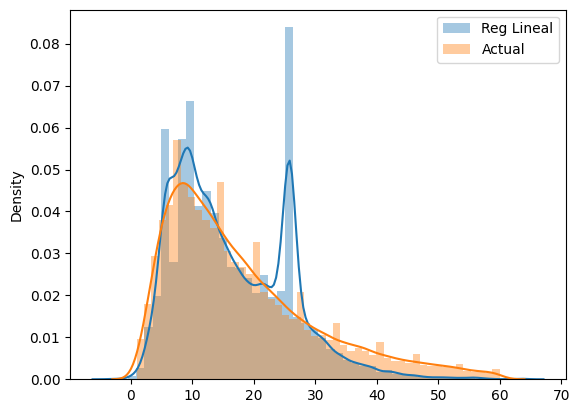

In [23]:
sns.distplot(y_pred_rl, label='Reg Lineal')
sns.distplot(y_val, label='Actual')
plt.legend();

In [35]:
# entrenando Regresion Lineal
rl_lasso = Lasso()
rl_lasso.fit(X_train, y_train)

y_pred_lasso = rl_lasso.predict(X_val)

print(mean_squared_error(y_val, y_pred_lasso, squared=False))

12.212583224318818


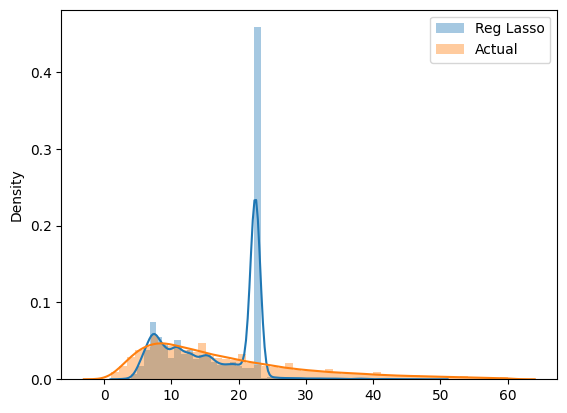

In [40]:
sns.distplot(y_pred_lasso, label='Reg Lasso')
sns.distplot(y_val, label='Actual')
plt.legend();

## Guardando los modelos

In [26]:
import pickle
with open("models/lin_reg.bin", "wb") as f:
    pickle.dump((dv, rl), f)

entrenando Regresion Lasso

```
rl_lasso = Lasso(0.001)
rl_lasso.fit(X_train, y_train)
y_pred_lasso = rl_lasso.predict(X_val)
```

In [37]:
with mlflow.start_run():

    mlflow.set_tag('developer', 'carlos ceron')
    # sobre simplificacion de versionamiento de datos
    mlflow.log_param("train-data-path", "../01-intro/data/green_tripdata_2021-01.parquet")
    mlflow.log_param("validation-data-path", "../01-intro/data/green_tripdata_2021-02.parquet")
    
    alpha = 0.01
    mlflow.log_param("alpha", alpha)

    # Llevando seguimiento del entrenamiento en MLflow
    lasso = Lasso(0.001)
    lasso.fit(X_train, y_train)

    y_pred_lasso = lasso.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred_lasso, squared=False)

    mlflow.log_metric("rmse", rmse)

In [38]:
print(rmse)

9.233436225720547


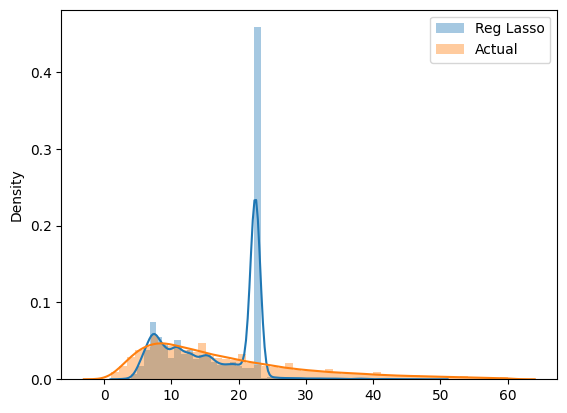

In [41]:
sns.distplot(y_pred_lasso, label='Reg Lasso')
sns.distplot(y_val, label='Actual')
plt.legend();

## Entrenando otro tipo de modelo para comparat

In [52]:
#!pip install xgboost
import xgboost as xgb

In [51]:
# !pip install hyperopt
# libreria que usa metodos bayesianos para encontrar la mejor combinacion de hiperparametros
# el modelo se convierte en una funcion que tiene inputs y produce outputs
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

# fmin: funcion para minimizar el objetivo
# tpe: algorimo que controla esta logiva
# hp: libreria que contiene metodos para definir los rangos de los hiperparametros. Define el espacio de busqueda.
# STATUS_OK: senal que mandaremos al final de cada corrida, para que hyperopt sepa que la funcion objetivo se ejecuto correctamente
# Trials: llevara registro de la informacion de cada corrida
# scope: la usaremos para definir un rango de typo int


In [53]:
# primero tenemos que definir la funcion objetivo

def funcion_objetivo(parametros, train_set, validation_set):

    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(parametros)

        xg = xgb.train(
            params=parametros,
            dtrain=train_set,
            num_boost_round=1000,
            evals=[(validation_set,"validation")],
            early_stopping_rounds=50
        )

        y_pred = xg.predict(validation_set)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {"loss": rmse, "status": STATUS_OK}

In [56]:
search_space = {
    "max_depth": scope.int(hp.quniform("max_depth", 4, 100, 1)),
    "learning_rate": hp.loguniform("learning_rate", -3, 0), # exp(-3) hasta exp(0) - (0.05, 1.0)
    "reg_alpha": hp.loguniform("reg_alpha", -5, -1),
    "reg_lambda": hp.loguniform("reg_lambda", -6, -1),
    "min_child_weight": hp.loguniform("min_child_weight", -1, 3),
    "objective": "reg_linear",
    "seed": 42,
}

In [ ]:
best_result = fmin(
    fn=funcion_objetivo,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)